# Feature Visualization Analysis

This notebook visualizes and analyzes different types of features extracted from the ISIC 2019 dataset to help understand what each feature type captures about the skin lesion images.

## Feature Types Available:
- **Color Features**: RGB color statistics and distributions
- **HSV Color Features**: Hue, Saturation, Value color space features
- **Circularity Features**: Shape and geometric properties
- **Contrast Features**: Local contrast and edge information
- **HOG Features**: Histogram of Oriented Gradients for texture/shape
- **LBP Features**: Local Binary Patterns for texture analysis
- **GLCM Features**: Gray-Level Co-occurrence Matrix for texture
- **Laplace Features**: Edge detection and sharpness measures
- **Wavelet Features**: Multi-scale texture and frequency analysis
- **EfficientNet Features**: Deep learning features from pre-trained CNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Define paths
feature_dir = Path("../pipeline_output/features/final/isic_2019")
print(f"Feature directory: {feature_dir}")
print(f"Directory exists: {feature_dir.exists()}")

# List all feature files
if feature_dir.exists():
    feature_files = list(feature_dir.glob("*.npy"))
    print(f"\nFound {len(feature_files)} feature files:")
    for f in sorted(feature_files):
        print(f"  - {f.name}")
else:
    print("Feature directory not found!")

Feature directory: ../pipeline_output/features/final/isic_2019
Directory exists: True

Found 10 feature files:
  - circularity_features.npy
  - color_features.npy
  - contrast_features.npy
  - efficientnet_features.npy
  - glcm_features.npy
  - hog_features.npy
  - hsv_color_features.npy
  - laplace_features.npy
  - lbp_features.npy
  - wavelet_features.npy


In [2]:
# Load and examine all feature files
features_data = {}
feature_info = {}

print("Loading feature files and examining their structure...")
print("=" * 60)

for feature_file in sorted(feature_files):
    feature_name = feature_file.stem
    
    try:
        # Load the feature data
        data = np.load(feature_file)
        features_data[feature_name] = data
        
        # Store basic info
        feature_info[feature_name] = {
            'shape': data.shape,
            'dtype': str(data.dtype),
            'size_mb': data.nbytes / (1024 * 1024),
            'min_val': float(np.min(data)),
            'max_val': float(np.max(data)),
            'mean_val': float(np.mean(data)),
            'std_val': float(np.std(data))
        }
        
        print(f"\n{feature_name.upper()}:")
        print(f"  Shape: {data.shape}")
        print(f"  Data type: {data.dtype}")
        print(f"  Size: {data.nbytes / (1024 * 1024):.2f} MB")
        print(f"  Value range: [{np.min(data):.4f}, {np.max(data):.4f}]")
        print(f"  Mean ± Std: {np.mean(data):.4f} ± {np.std(data):.4f}")
        
        if data.shape[1] <= 20:
            print(f"  Feature dimensions: {data.shape[1]}")
        else:
            print(f"  Feature dimensions: {data.shape[1]} (high-dimensional)")
            
    except Exception as e:
        print(f"Error loading {feature_name}: {e}")

print(f"\n" + "=" * 60)
print(f"Successfully loaded {len(features_data)} feature types")
print(f"Total samples across all features: {list(features_data.values())[0].shape[0] if features_data else 0}")

Loading feature files and examining their structure...

CIRCULARITY_FEATURES:
  Shape: (8000, 3)
  Data type: float64
  Size: 0.18 MB
  Value range: [0.0000, 1.0000]
  Mean ± Std: 0.5091 ± 0.2533
  Feature dimensions: 3

COLOR_FEATURES:
  Shape: (8000, 96)
  Data type: float64
  Size: 5.86 MB
  Value range: [0.0000, 32.0000]
  Mean ± Std: 1.0000 ± 2.5635
  Feature dimensions: 96 (high-dimensional)

CONTRAST_FEATURES:
  Shape: (8000, 4)
  Data type: float64
  Size: 0.24 MB
  Value range: [0.0000, 189.9000]
  Mean ± Std: 33.5858 ± 28.2916
  Feature dimensions: 4

EFFICIENTNET_FEATURES:
  Shape: (8000, 153600)
  Data type: float32
  Size: 4687.50 MB

EFFICIENTNET_FEATURES:
  Shape: (8000, 153600)
  Data type: float32
  Size: 4687.50 MB
  Value range: [-0.2785, 58.2101]
  Value range: [-0.2785, 58.2101]
  Mean ± Std: 0.0293 ± 0.8899
  Feature dimensions: 153600 (high-dimensional)

GLCM_FEATURES:
  Shape: (8000, 72)
  Data type: float64
  Size: 4.39 MB
  Value range: [0.0016, 91.3756]
  Mea

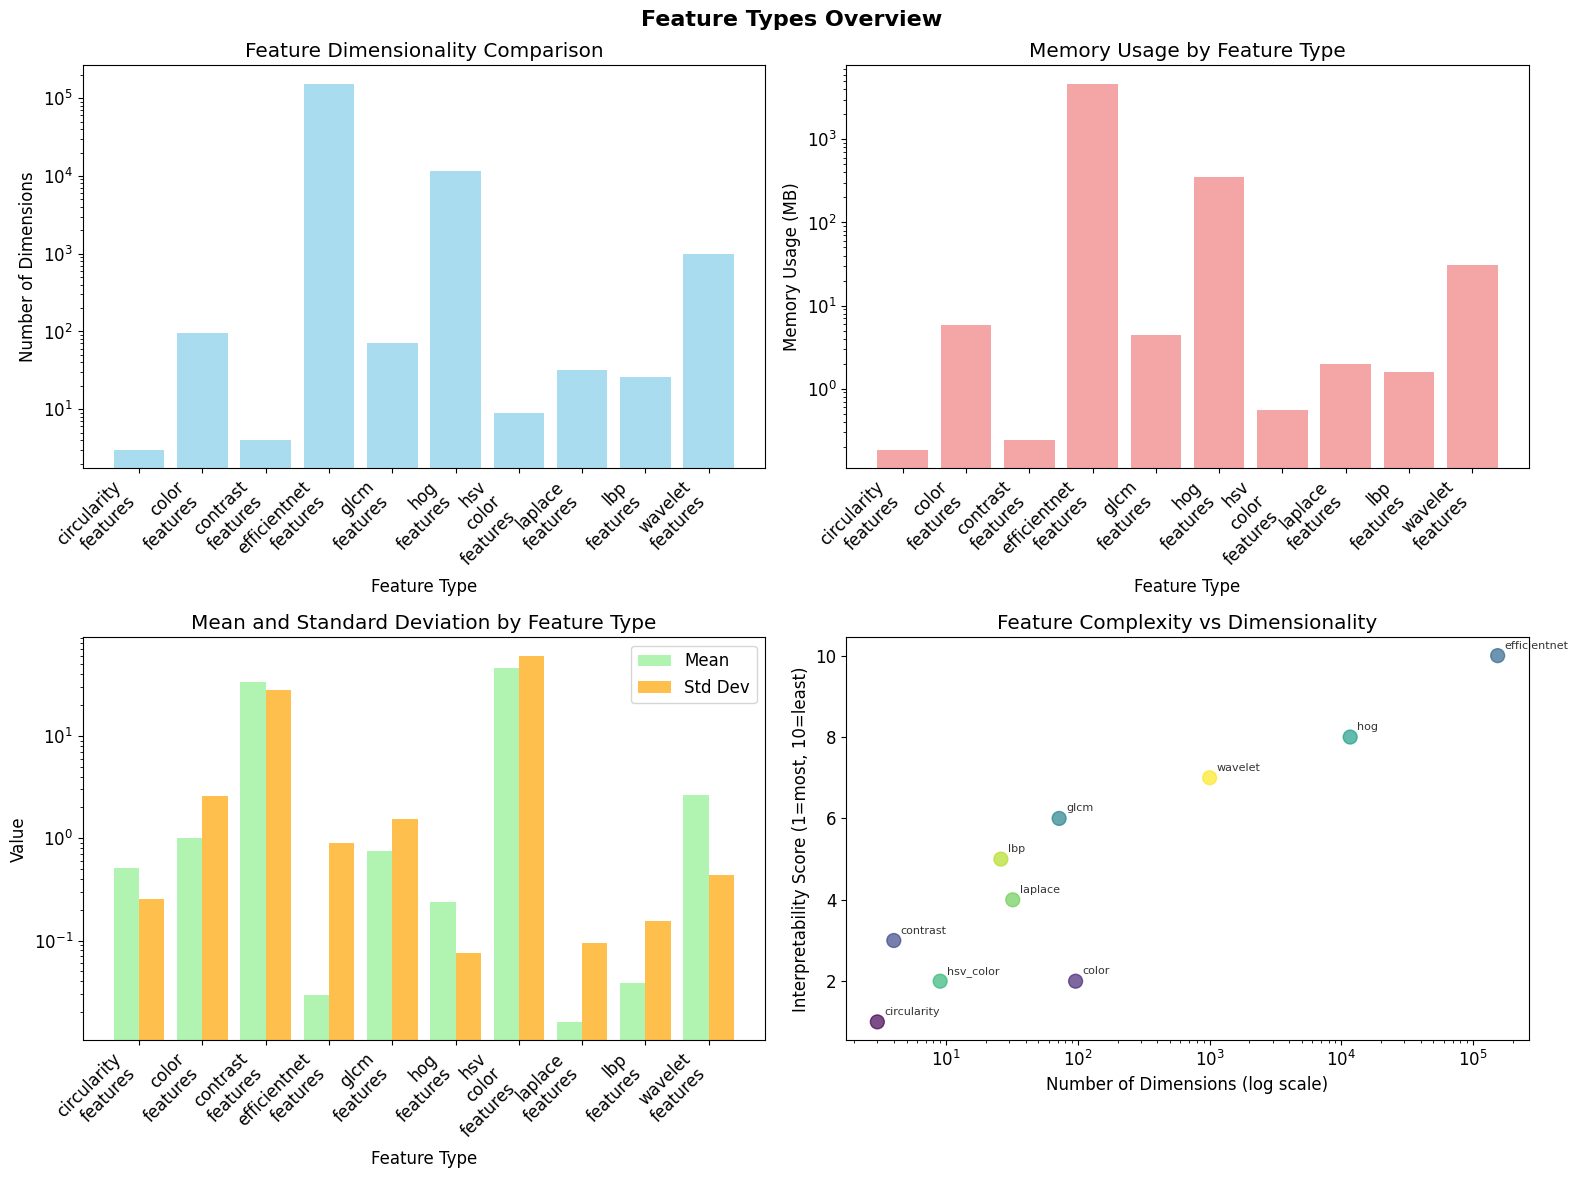


Feature Summary Table:
                                shape    dtype     size_mb   min_val  \
circularity_features        (8000, 3)  float64    0.183105       0.0   
color_features             (8000, 96)  float64    5.859375       0.0   
contrast_features           (8000, 4)  float64    0.244141       0.0   
efficientnet_features  (8000, 153600)  float32      4687.5 -0.278465   
glcm_features              (8000, 72)  float64    4.394531  0.001616   
hog_features            (8000, 11664)  float32  355.957031       0.0   
hsv_color_features          (8000, 9)  float64    0.549316  0.289075   
laplace_features           (8000, 32)  float64    1.953125       0.0   
lbp_features               (8000, 26)  float64    1.586914       0.0   
wavelet_features         (8000, 1000)  float32   30.517578       0.0   

                          max_val   mean_val    std_val  
circularity_features          1.0   0.509105   0.253326  
color_features               32.0        1.0   2.563503  
contrast_

In [3]:
# Create a summary visualization of all feature types
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature Types Overview', fontsize=16, fontweight='bold')

# 1. Feature dimensions comparison
feature_names = list(feature_info.keys())
dimensions = [feature_info[name]['shape'][1] for name in feature_names]

axes[0, 0].bar(range(len(feature_names)), dimensions, color='skyblue', alpha=0.7)
axes[0, 0].set_xlabel('Feature Type')
axes[0, 0].set_ylabel('Number of Dimensions')
axes[0, 0].set_title('Feature Dimensionality Comparison')
axes[0, 0].set_xticks(range(len(feature_names)))
axes[0, 0].set_xticklabels([name.replace('_', '\n') for name in feature_names], rotation=45, ha='right')
axes[0, 0].set_yscale('log')  # Log scale due to large differences

# 2. Memory usage comparison
sizes_mb = [feature_info[name]['size_mb'] for name in feature_names]
axes[0, 1].bar(range(len(feature_names)), sizes_mb, color='lightcoral', alpha=0.7)
axes[0, 1].set_xlabel('Feature Type')
axes[0, 1].set_ylabel('Memory Usage (MB)')
axes[0, 1].set_title('Memory Usage by Feature Type')
axes[0, 1].set_xticks(range(len(feature_names)))
axes[0, 1].set_xticklabels([name.replace('_', '\n') for name in feature_names], rotation=45, ha='right')
axes[0, 1].set_yscale('log')

# 3. Value range comparison (normalized)
means = [feature_info[name]['mean_val'] for name in feature_names]
stds = [feature_info[name]['std_val'] for name in feature_names]

x_pos = np.arange(len(feature_names))
axes[1, 0].bar(x_pos - 0.2, means, 0.4, label='Mean', color='lightgreen', alpha=0.7)
axes[1, 0].bar(x_pos + 0.2, stds, 0.4, label='Std Dev', color='orange', alpha=0.7)
axes[1, 0].set_xlabel('Feature Type')
axes[1, 0].set_ylabel('Value')
axes[1, 0].set_title('Mean and Standard Deviation by Feature Type')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels([name.replace('_', '\n') for name in feature_names], rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].set_yscale('log')

# 4. Feature complexity vs interpretability (subjective ranking)
complexity_scores = {
    'circularity_features': 1,  # Very interpretable
    'color_features': 2,
    'hsv_color_features': 2,
    'contrast_features': 3,
    'laplace_features': 4,
    'lbp_features': 5,
    'glcm_features': 6,
    'wavelet_features': 7,
    'hog_features': 8,
    'efficientnet_features': 10  # Least interpretable
}

complexity = [complexity_scores[name] for name in feature_names]
scatter_colors = plt.cm.viridis(np.linspace(0, 1, len(feature_names)))

scatter = axes[1, 1].scatter(dimensions, complexity, c=scatter_colors, s=100, alpha=0.7)
axes[1, 1].set_xlabel('Number of Dimensions (log scale)')
axes[1, 1].set_ylabel('Interpretability Score (1=most, 10=least)')
axes[1, 1].set_title('Feature Complexity vs Dimensionality')
axes[1, 1].set_xscale('log')

# Add labels to scatter plot
for i, name in enumerate(feature_names):
    axes[1, 1].annotate(name.replace('_features', ''), 
                       (dimensions[i], complexity[i]), 
                       xytext=(5, 5), textcoords='offset points', 
                       fontsize=8, alpha=0.8)

plt.tight_layout()
plt.show()

# Print summary table
print("\nFeature Summary Table:")
print("=" * 100)
df_summary = pd.DataFrame(feature_info).T
df_summary = df_summary.round(4)
print(df_summary)

## Detailed Analysis of Interpretable Features

Let's examine the most interpretable features in detail to understand what each captures about the skin lesions.

=== CIRCULARITY FEATURES ANALYSIS ===
These features capture the shape characteristics of lesions:
- How circular/round vs irregular the lesion boundary is
- Shape compactness and regularity measures
- Geometric properties that may indicate malignancy

Shape: (8000, 3)
Likely features: [circularity_ratio, compactness, irregularity_index]


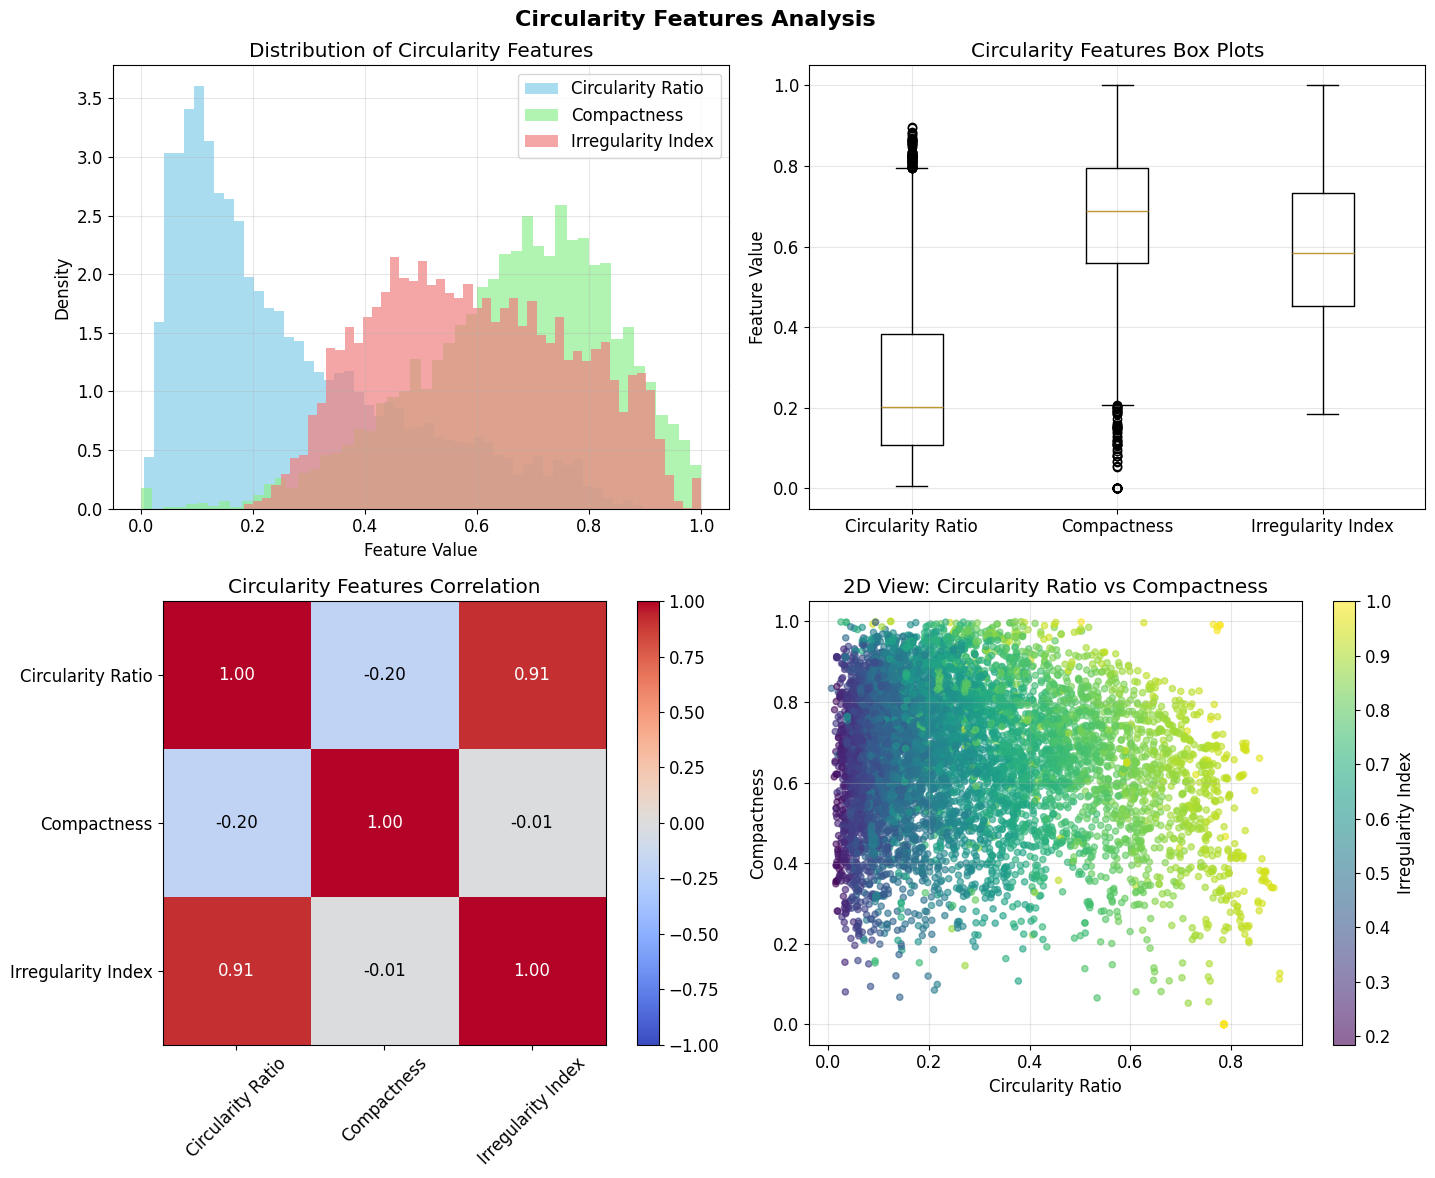


Circularity Features Statistics:
Circularity Ratio:
  Mean: 0.2662
  Std:  0.1996
  Min:  0.0063
  Max:  0.8965
  Median: 0.2028

Compactness:
  Mean: 0.6672
  Std:  0.1752
  Min:  0.0000
  Max:  1.0000
  Median: 0.6882

Irregularity Index:
  Mean: 0.5939
  Std:  0.1755
  Min:  0.1842
  Max:  1.0000
  Median: 0.5831



In [4]:
# 1. CIRCULARITY FEATURES - Shape and geometric properties
print("=== CIRCULARITY FEATURES ANALYSIS ===")
print("These features capture the shape characteristics of lesions:")
print("- How circular/round vs irregular the lesion boundary is")
print("- Shape compactness and regularity measures")
print("- Geometric properties that may indicate malignancy")

circularity_data = features_data['circularity_features']
print(f"\nShape: {circularity_data.shape}")
print("Likely features: [circularity_ratio, compactness, irregularity_index]")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Circularity Features Analysis', fontsize=16, fontweight='bold')

# Distribution of each circularity feature
feature_labels = ['Circularity Ratio', 'Compactness', 'Irregularity Index']
colors = ['skyblue', 'lightgreen', 'lightcoral']

for i in range(3):
    axes[0, 0].hist(circularity_data[:, i], bins=50, alpha=0.7, 
                   label=feature_labels[i], color=colors[i], density=True)
axes[0, 0].set_xlabel('Feature Value')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Distribution of Circularity Features')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Box plots for comparison
axes[0, 1].boxplot([circularity_data[:, i] for i in range(3)], 
                  labels=feature_labels)
axes[0, 1].set_title('Circularity Features Box Plots')
axes[0, 1].set_ylabel('Feature Value')
axes[0, 1].grid(True, alpha=0.3)

# Correlation between circularity features
correlation_matrix = np.corrcoef(circularity_data.T)
im = axes[1, 0].imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
axes[1, 0].set_title('Circularity Features Correlation')
axes[1, 0].set_xticks(range(3))
axes[1, 0].set_yticks(range(3))
axes[1, 0].set_xticklabels(feature_labels, rotation=45)
axes[1, 0].set_yticklabels(feature_labels)

# Add correlation values to the plot
for i in range(3):
    for j in range(3):
        text = axes[1, 0].text(j, i, f'{correlation_matrix[i, j]:.2f}',
                              ha="center", va="center", color="black" if abs(correlation_matrix[i, j]) < 0.5 else "white")

plt.colorbar(im, ax=axes[1, 0])

# 2D scatter plot of circularity features
scatter = axes[1, 1].scatter(circularity_data[:, 0], circularity_data[:, 1], 
                           c=circularity_data[:, 2], cmap='viridis', alpha=0.6, s=20)
axes[1, 1].set_xlabel(feature_labels[0])
axes[1, 1].set_ylabel(feature_labels[1])
axes[1, 1].set_title(f'2D View: {feature_labels[0]} vs {feature_labels[1]}')
axes[1, 1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 1], label=feature_labels[2])

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nCircularity Features Statistics:")
for i, label in enumerate(feature_labels):
    data = circularity_data[:, i]
    print(f"{label}:")
    print(f"  Mean: {np.mean(data):.4f}")
    print(f"  Std:  {np.std(data):.4f}")
    print(f"  Min:  {np.min(data):.4f}")
    print(f"  Max:  {np.max(data):.4f}")
    print(f"  Median: {np.median(data):.4f}")
    print()

=== CONTRAST FEATURES ANALYSIS ===
These features capture contrast and edge characteristics:
- Local contrast variations within the lesion
- Edge sharpness and boundary definition
- Texture contrast that may indicate surface irregularities

Shape: (8000, 4)
Likely features: [RMS_contrast, Michelson_contrast, Weber_contrast, Edge_contrast]


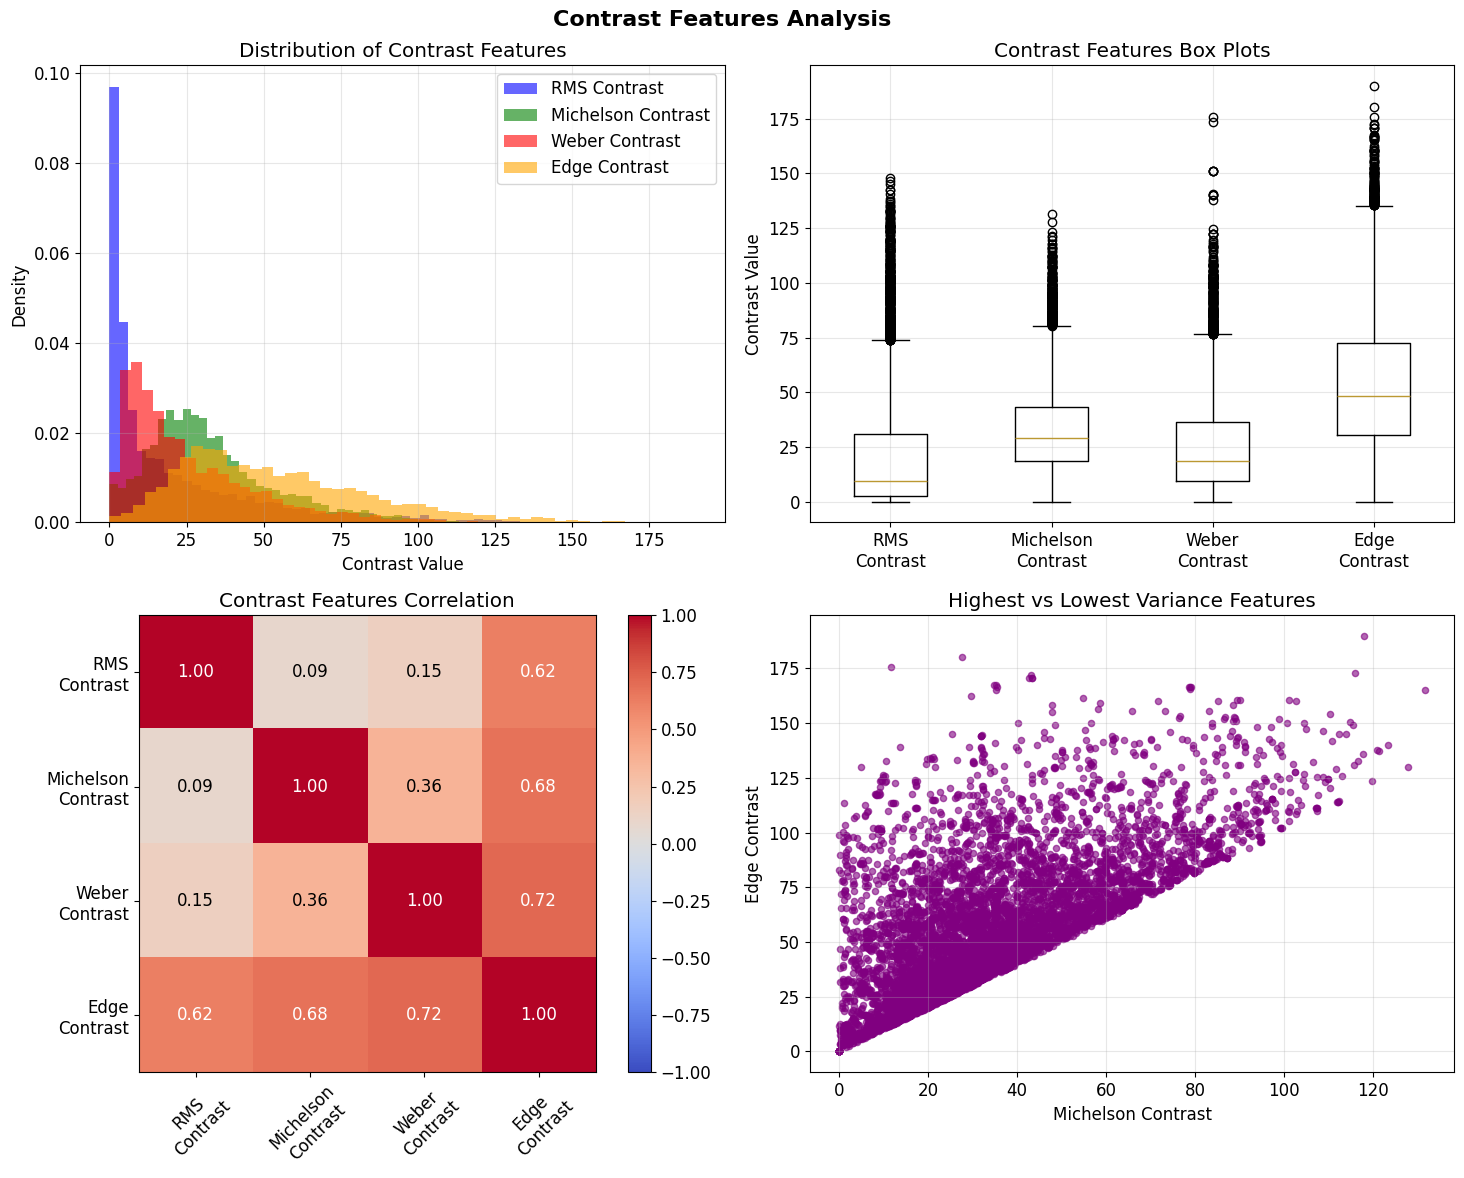


Contrast Features Statistics:
RMS Contrast:
  Mean: 21.2300
  Std:  26.6499
  Min:  0.0000
  Max:  147.8013
  Median: 9.3631

Michelson Contrast:
  Mean: 33.3135
  Std:  20.9502
  Min:  0.0000
  Max:  131.6045
  Median: 28.9715

Weber Contrast:
  Mean: 25.8074
  Std:  21.9360
  Min:  0.0000
  Max:  175.7257
  Median: 18.7377

Edge Contrast:
  Mean: 53.9922
  Std:  30.6868
  Min:  0.0000
  Max:  189.9000
  Median: 48.3439



In [5]:
# 2. CONTRAST FEATURES - Local contrast and edge information
print("=== CONTRAST FEATURES ANALYSIS ===")
print("These features capture contrast and edge characteristics:")
print("- Local contrast variations within the lesion")
print("- Edge sharpness and boundary definition")
print("- Texture contrast that may indicate surface irregularities")

contrast_data = features_data['contrast_features']
print(f"\nShape: {contrast_data.shape}")
print("Likely features: [RMS_contrast, Michelson_contrast, Weber_contrast, Edge_contrast]")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Contrast Features Analysis', fontsize=16, fontweight='bold')

# Distribution of each contrast feature
feature_labels = ['RMS Contrast', 'Michelson Contrast', 'Weber Contrast', 'Edge Contrast']
colors = ['blue', 'green', 'red', 'orange']

for i in range(4):
    axes[0, 0].hist(contrast_data[:, i], bins=50, alpha=0.6, 
                   label=feature_labels[i], color=colors[i], density=True)
axes[0, 0].set_xlabel('Contrast Value')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Distribution of Contrast Features')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Box plots for comparison
box_data = [contrast_data[:, i] for i in range(4)]
bp = axes[0, 1].boxplot(box_data, labels=[label.replace(' ', '\n') for label in feature_labels])
axes[0, 1].set_title('Contrast Features Box Plots')
axes[0, 1].set_ylabel('Contrast Value')
axes[0, 1].grid(True, alpha=0.3)

# Correlation between contrast features
correlation_matrix = np.corrcoef(contrast_data.T)
im = axes[1, 0].imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
axes[1, 0].set_title('Contrast Features Correlation')
axes[1, 0].set_xticks(range(4))
axes[1, 0].set_yticks(range(4))
axes[1, 0].set_xticklabels([label.replace(' ', '\n') for label in feature_labels], rotation=45)
axes[1, 0].set_yticklabels([label.replace(' ', '\n') for label in feature_labels])

# Add correlation values
for i in range(4):
    for j in range(4):
        text = axes[1, 0].text(j, i, f'{correlation_matrix[i, j]:.2f}',
                              ha="center", va="center", 
                              color="black" if abs(correlation_matrix[i, j]) < 0.5 else "white")

plt.colorbar(im, ax=axes[1, 0])

# Contrast feature relationships
# Plot the two most different features
max_contrast_idx = np.argmax(np.std(contrast_data, axis=0))
min_contrast_idx = np.argmin(np.std(contrast_data, axis=0))

scatter = axes[1, 1].scatter(contrast_data[:, min_contrast_idx], contrast_data[:, max_contrast_idx], 
                           alpha=0.6, s=20, c='purple')
axes[1, 1].set_xlabel(feature_labels[min_contrast_idx])
axes[1, 1].set_ylabel(feature_labels[max_contrast_idx])
axes[1, 1].set_title(f'Highest vs Lowest Variance Features')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nContrast Features Statistics:")
for i, label in enumerate(feature_labels):
    data = contrast_data[:, i]
    print(f"{label}:")
    print(f"  Mean: {np.mean(data):.4f}")
    print(f"  Std:  {np.std(data):.4f}")
    print(f"  Min:  {np.min(data):.4f}")
    print(f"  Max:  {np.max(data):.4f}")
    print(f"  Median: {np.median(data):.4f}")
    print()

=== HSV COLOR FEATURES ANALYSIS ===
These features capture color characteristics in HSV space:
- Hue: Dominant color tones (useful for melanoma vs benign)
- Saturation: Color intensity and purity
- Value: Brightness and luminosity
- Statistical measures: mean, std, skewness of H, S, V channels

Shape: (8000, 9)
Likely features: [H_mean, H_std, H_skew, S_mean, S_std, S_skew, V_mean, V_std, V_skew]


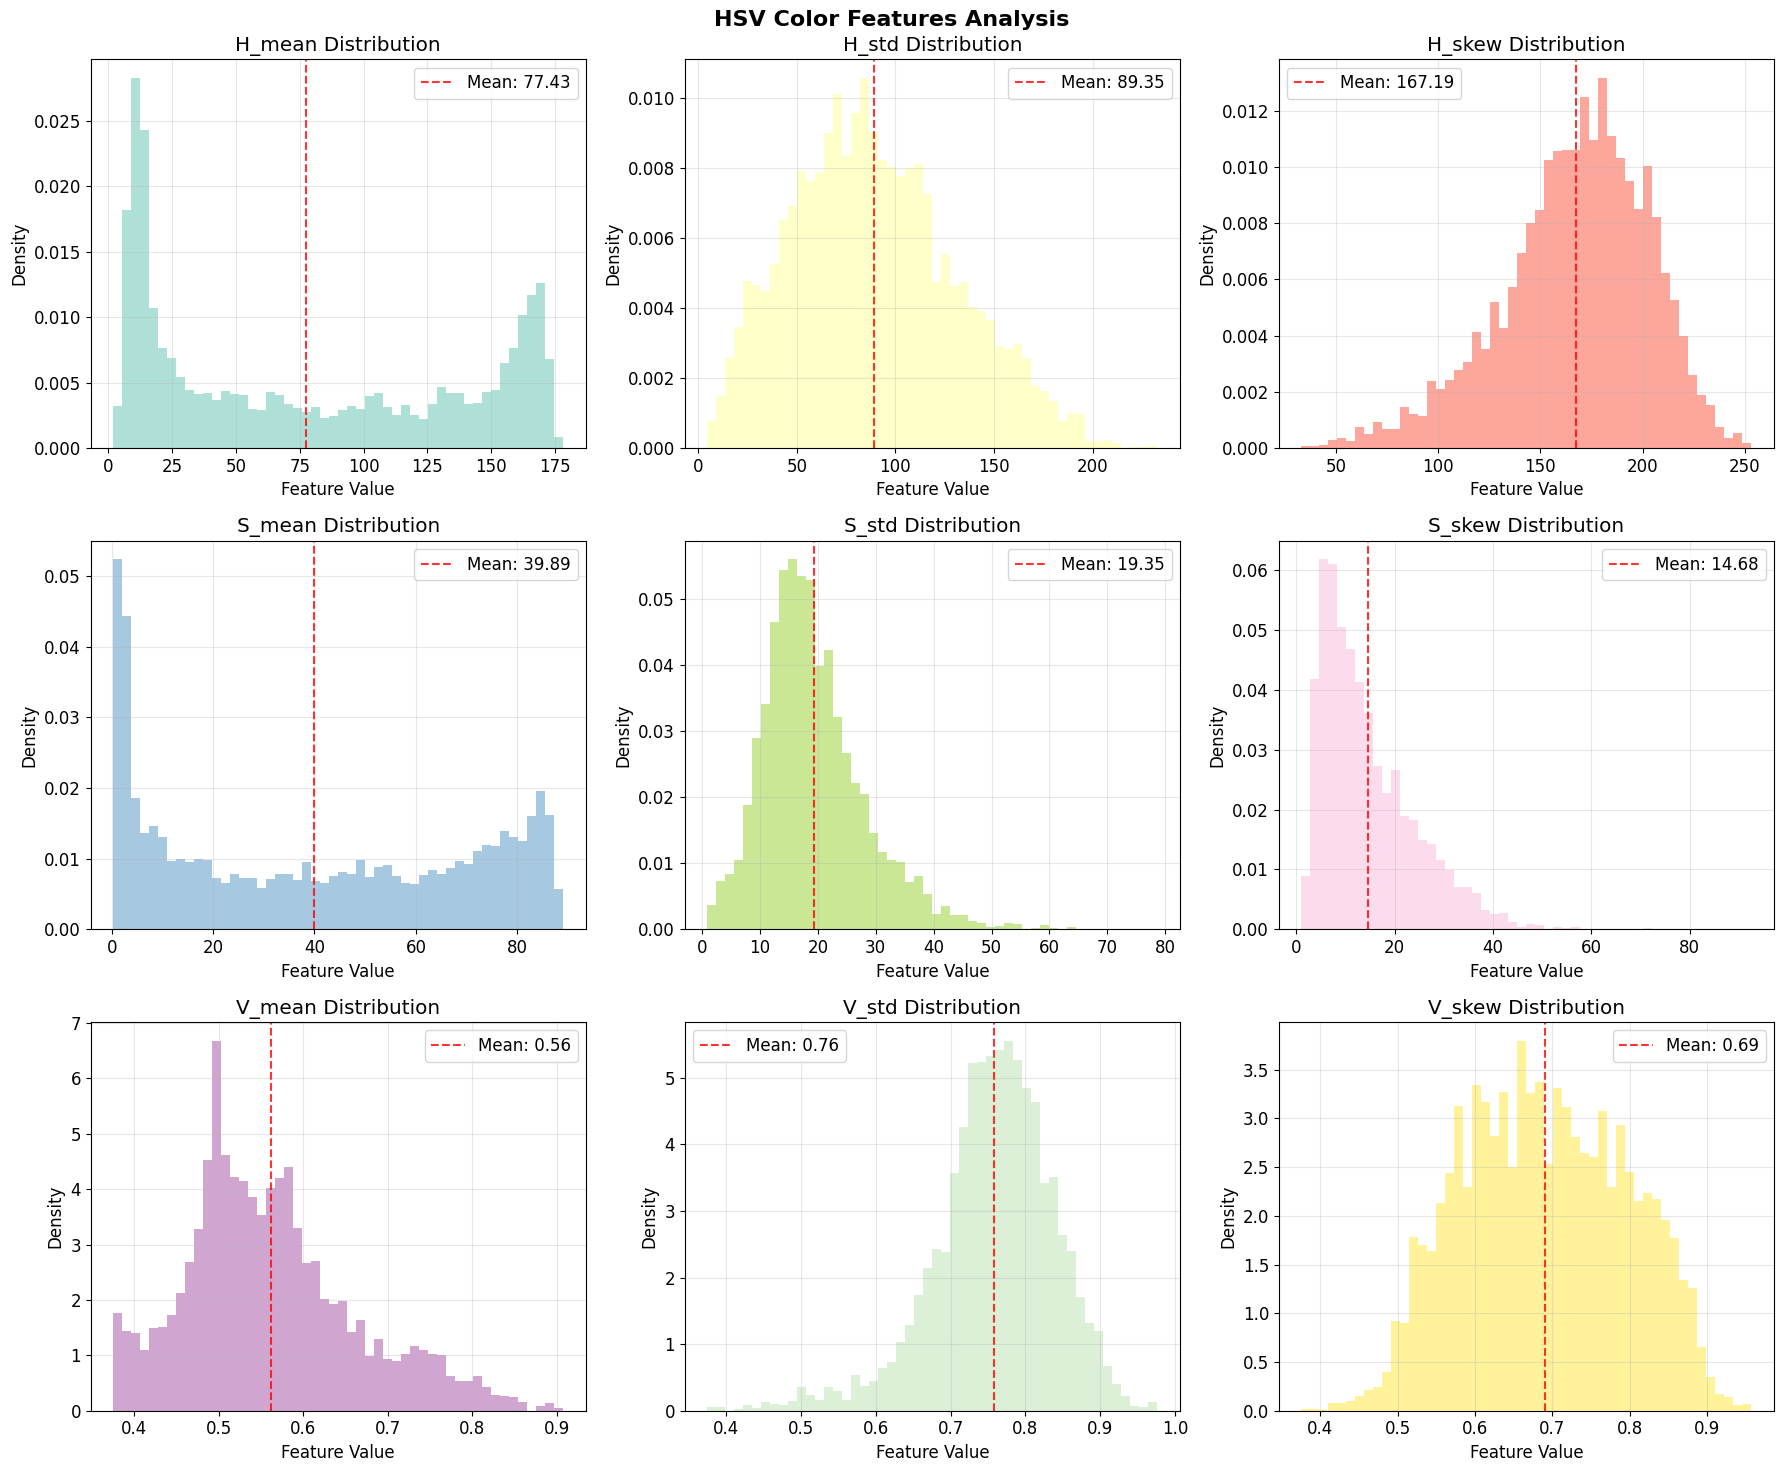

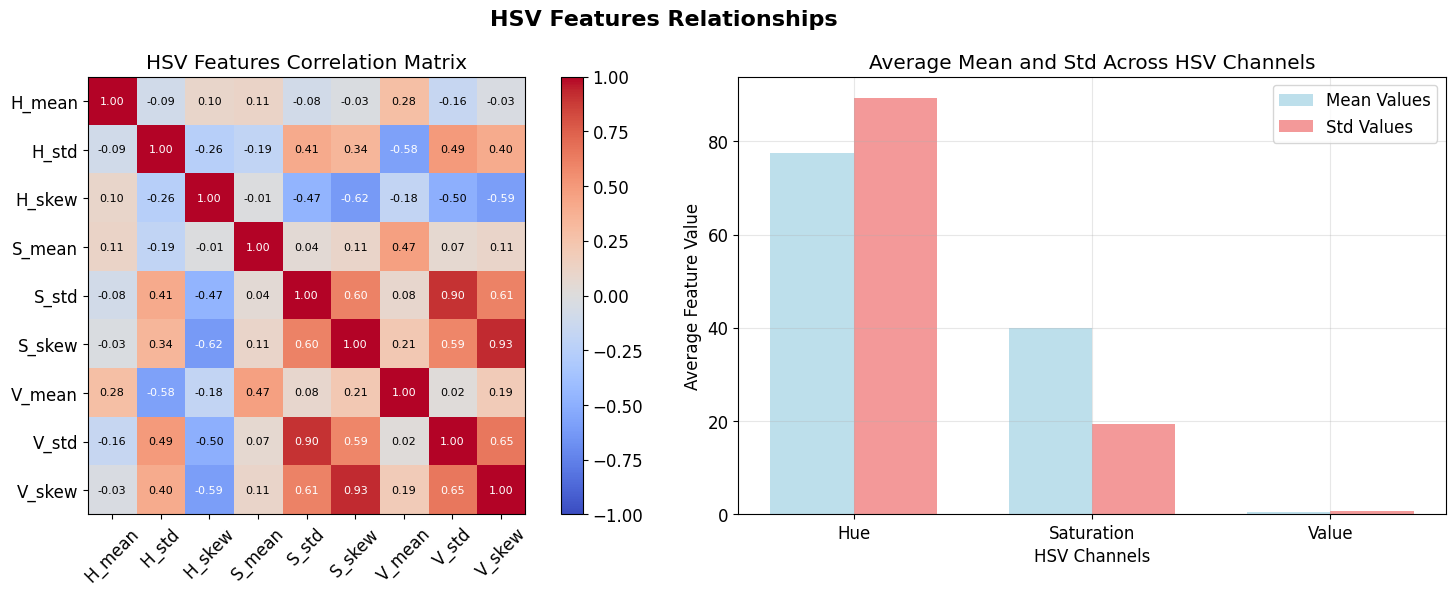


HSV Features Statistics:
H_mean:
  Mean: 77.4251
  Std:  60.8200
  Min:  1.9789
  Max:  178.2498
  Median: 64.1819
H_std:
  Mean: 89.3505
  Std:  41.5271
  Min:  4.5903
  Max:  232.8830
  Median: 85.7867
H_skew:
  Mean: 167.1948
  Std:  35.7783
  Min:  33.0801
  Max:  253.2447
  Median: 171.0112

S_mean:
  Mean: 39.8873
  Std:  30.1287
  Min:  0.2891
  Max:  89.0954
  Median: 38.3078
S_std:
  Mean: 19.3489
  Std:  8.8680
  Min:  0.8960
  Max:  78.6520
  Median: 17.9708
S_skew:
  Mean: 14.6821
  Std:  9.6561
  Min:  1.0203
  Max:  92.5362
  Median: 12.1140

V_mean:
  Mean: 0.5615
  Std:  0.1020
  Min:  0.3750
  Max:  0.9081
  Median: 0.5466
V_std:
  Mean: 0.7578
  Std:  0.0825
  Min:  0.3750
  Max:  0.9763
  Median: 0.7643
V_skew:
  Mean: 0.6906
  Std:  0.1059
  Min:  0.3753
  Max:  0.9576
  Median: 0.6863



In [6]:
# 3. HSV COLOR FEATURES - Hue, Saturation, Value color space
print("=== HSV COLOR FEATURES ANALYSIS ===")
print("These features capture color characteristics in HSV space:")
print("- Hue: Dominant color tones (useful for melanoma vs benign)")
print("- Saturation: Color intensity and purity")
print("- Value: Brightness and luminosity")
print("- Statistical measures: mean, std, skewness of H, S, V channels")

hsv_data = features_data['hsv_color_features']
print(f"\nShape: {hsv_data.shape}")
print("Likely features: [H_mean, H_std, H_skew, S_mean, S_std, S_skew, V_mean, V_std, V_skew]")

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('HSV Color Features Analysis', fontsize=16, fontweight='bold')

# Define feature labels for 9 HSV features
hsv_labels = ['H_mean', 'H_std', 'H_skew', 'S_mean', 'S_std', 'S_skew', 'V_mean', 'V_std', 'V_skew']
colors = plt.cm.Set3(np.linspace(0, 1, 9))

# Create subplots for each HSV feature
for i in range(9):
    row, col = i // 3, i % 3
    
    # Histogram of the feature
    axes[row, col].hist(hsv_data[:, i], bins=50, alpha=0.7, color=colors[i], density=True)
    axes[row, col].set_title(f'{hsv_labels[i]} Distribution')
    axes[row, col].set_xlabel('Feature Value')
    axes[row, col].set_ylabel('Density')
    axes[row, col].grid(True, alpha=0.3)
    
    # Add statistics text
    mean_val = np.mean(hsv_data[:, i])
    std_val = np.std(hsv_data[:, i])
    axes[row, col].axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.2f}')
    axes[row, col].legend()

plt.tight_layout()
plt.show()

# Create correlation analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('HSV Features Relationships', fontsize=16, fontweight='bold')

# Correlation heatmap
correlation_matrix = np.corrcoef(hsv_data.T)
im = axes[0].imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
axes[0].set_title('HSV Features Correlation Matrix')
axes[0].set_xticks(range(9))
axes[0].set_yticks(range(9))
axes[0].set_xticklabels(hsv_labels, rotation=45)
axes[0].set_yticklabels(hsv_labels)

# Add correlation values
for i in range(9):
    for j in range(9):
        text = axes[0].text(j, i, f'{correlation_matrix[i, j]:.2f}',
                           ha="center", va="center", fontsize=8,
                           color="black" if abs(correlation_matrix[i, j]) < 0.5 else "white")

plt.colorbar(im, ax=axes[0])

# HSV channel relationships (group by H, S, V)
h_features = hsv_data[:, 0:3]  # H_mean, H_std, H_skew
s_features = hsv_data[:, 3:6]  # S_mean, S_std, S_skew
v_features = hsv_data[:, 6:9]  # V_mean, V_std, V_skew

# Plot mean values for each channel
channel_means = [np.mean(h_features[:, 0]), np.mean(s_features[:, 0]), np.mean(v_features[:, 0])]
channel_stds = [np.mean(h_features[:, 1]), np.mean(s_features[:, 1]), np.mean(v_features[:, 1])]

x_pos = np.arange(3)
width = 0.35

bars1 = axes[1].bar(x_pos - width/2, channel_means, width, label='Mean Values', color='lightblue', alpha=0.8)
bars2 = axes[1].bar(x_pos + width/2, channel_stds, width, label='Std Values', color='lightcoral', alpha=0.8)

axes[1].set_xlabel('HSV Channels')
axes[1].set_ylabel('Average Feature Value')
axes[1].set_title('Average Mean and Std Across HSV Channels')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(['Hue', 'Saturation', 'Value'])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\nHSV Features Statistics:")
for i, label in enumerate(hsv_labels):
    data = hsv_data[:, i]
    print(f"{label}:")
    print(f"  Mean: {np.mean(data):.4f}")
    print(f"  Std:  {np.std(data):.4f}")
    print(f"  Min:  {np.min(data):.4f}")
    print(f"  Max:  {np.max(data):.4f}")
    print(f"  Median: {np.median(data):.4f}")
    if i % 3 == 2:  # Add separator after each channel group
        print()

## High-Dimensional Feature Analysis

We want to leverage T-SNE visualizations to determine if there are easily percieved patterns.

In [7]:
# Load metadata with class labels
print("=== LOADING CLASS LABELS ===")
metadata_path = "../pipeline_output/data/metadata/isic_2019_preprocessed.csv"
metadata_df = pd.read_csv(metadata_path)

print(f"Metadata shape: {metadata_df.shape}")
print(f"Available columns: {list(metadata_df.columns)}")
print(f"\nClass distribution:")
print(metadata_df['label'].value_counts())

# Get unique labels and create color mapping
unique_labels = sorted(metadata_df['label'].unique())
label_colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
label_color_map = dict(zip(unique_labels, label_colors))

print(f"\nUnique labels: {unique_labels}")
print(f"Number of classes: {len(unique_labels)}")

# Extract labels array for easy indexing
labels = metadata_df['label'].values
print(f"Labels array shape: {labels.shape}")
print(f"Features data shape: {list(features_data.values())[0].shape[0]}")

# Verify alignment
if len(labels) == list(features_data.values())[0].shape[0]:
    print("✓ Labels and features are properly aligned")
else:
    print("⚠ Warning: Labels and features may not be aligned")

=== LOADING CLASS LABELS ===
Metadata shape: (8000, 7)
Available columns: ['original_image', 'processed_image', 'local_path', 'label', 'augmentation', 'width', 'height']

Class distribution:
label
NV      1000
MEL     1000
BCC     1000
BKL     1000
AK      1000
SCC     1000
VASC    1000
DF      1000
Name: count, dtype: int64

Unique labels: ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']
Number of classes: 8
Labels array shape: (8000,)
Features data shape: 8000
✓ Labels and features are properly aligned


=== t-SNE VISUALIZATION OF FEATURE SPACES WITH CLASS LABELS ===
Comparing how different feature types cluster and separate samples by diagnosis

Processing circularity_features...

Processing color_features...

Processing color_features...

Processing contrast_features...

Processing contrast_features...

Processing glcm_features...

Processing glcm_features...

Processing hog_features...

Processing hog_features...

Processing hsv_color_features...

Processing hsv_color_features...

Processing laplace_features...

Processing laplace_features...

Processing lbp_features...

Processing lbp_features...

Processing wavelet_features...

Processing wavelet_features...


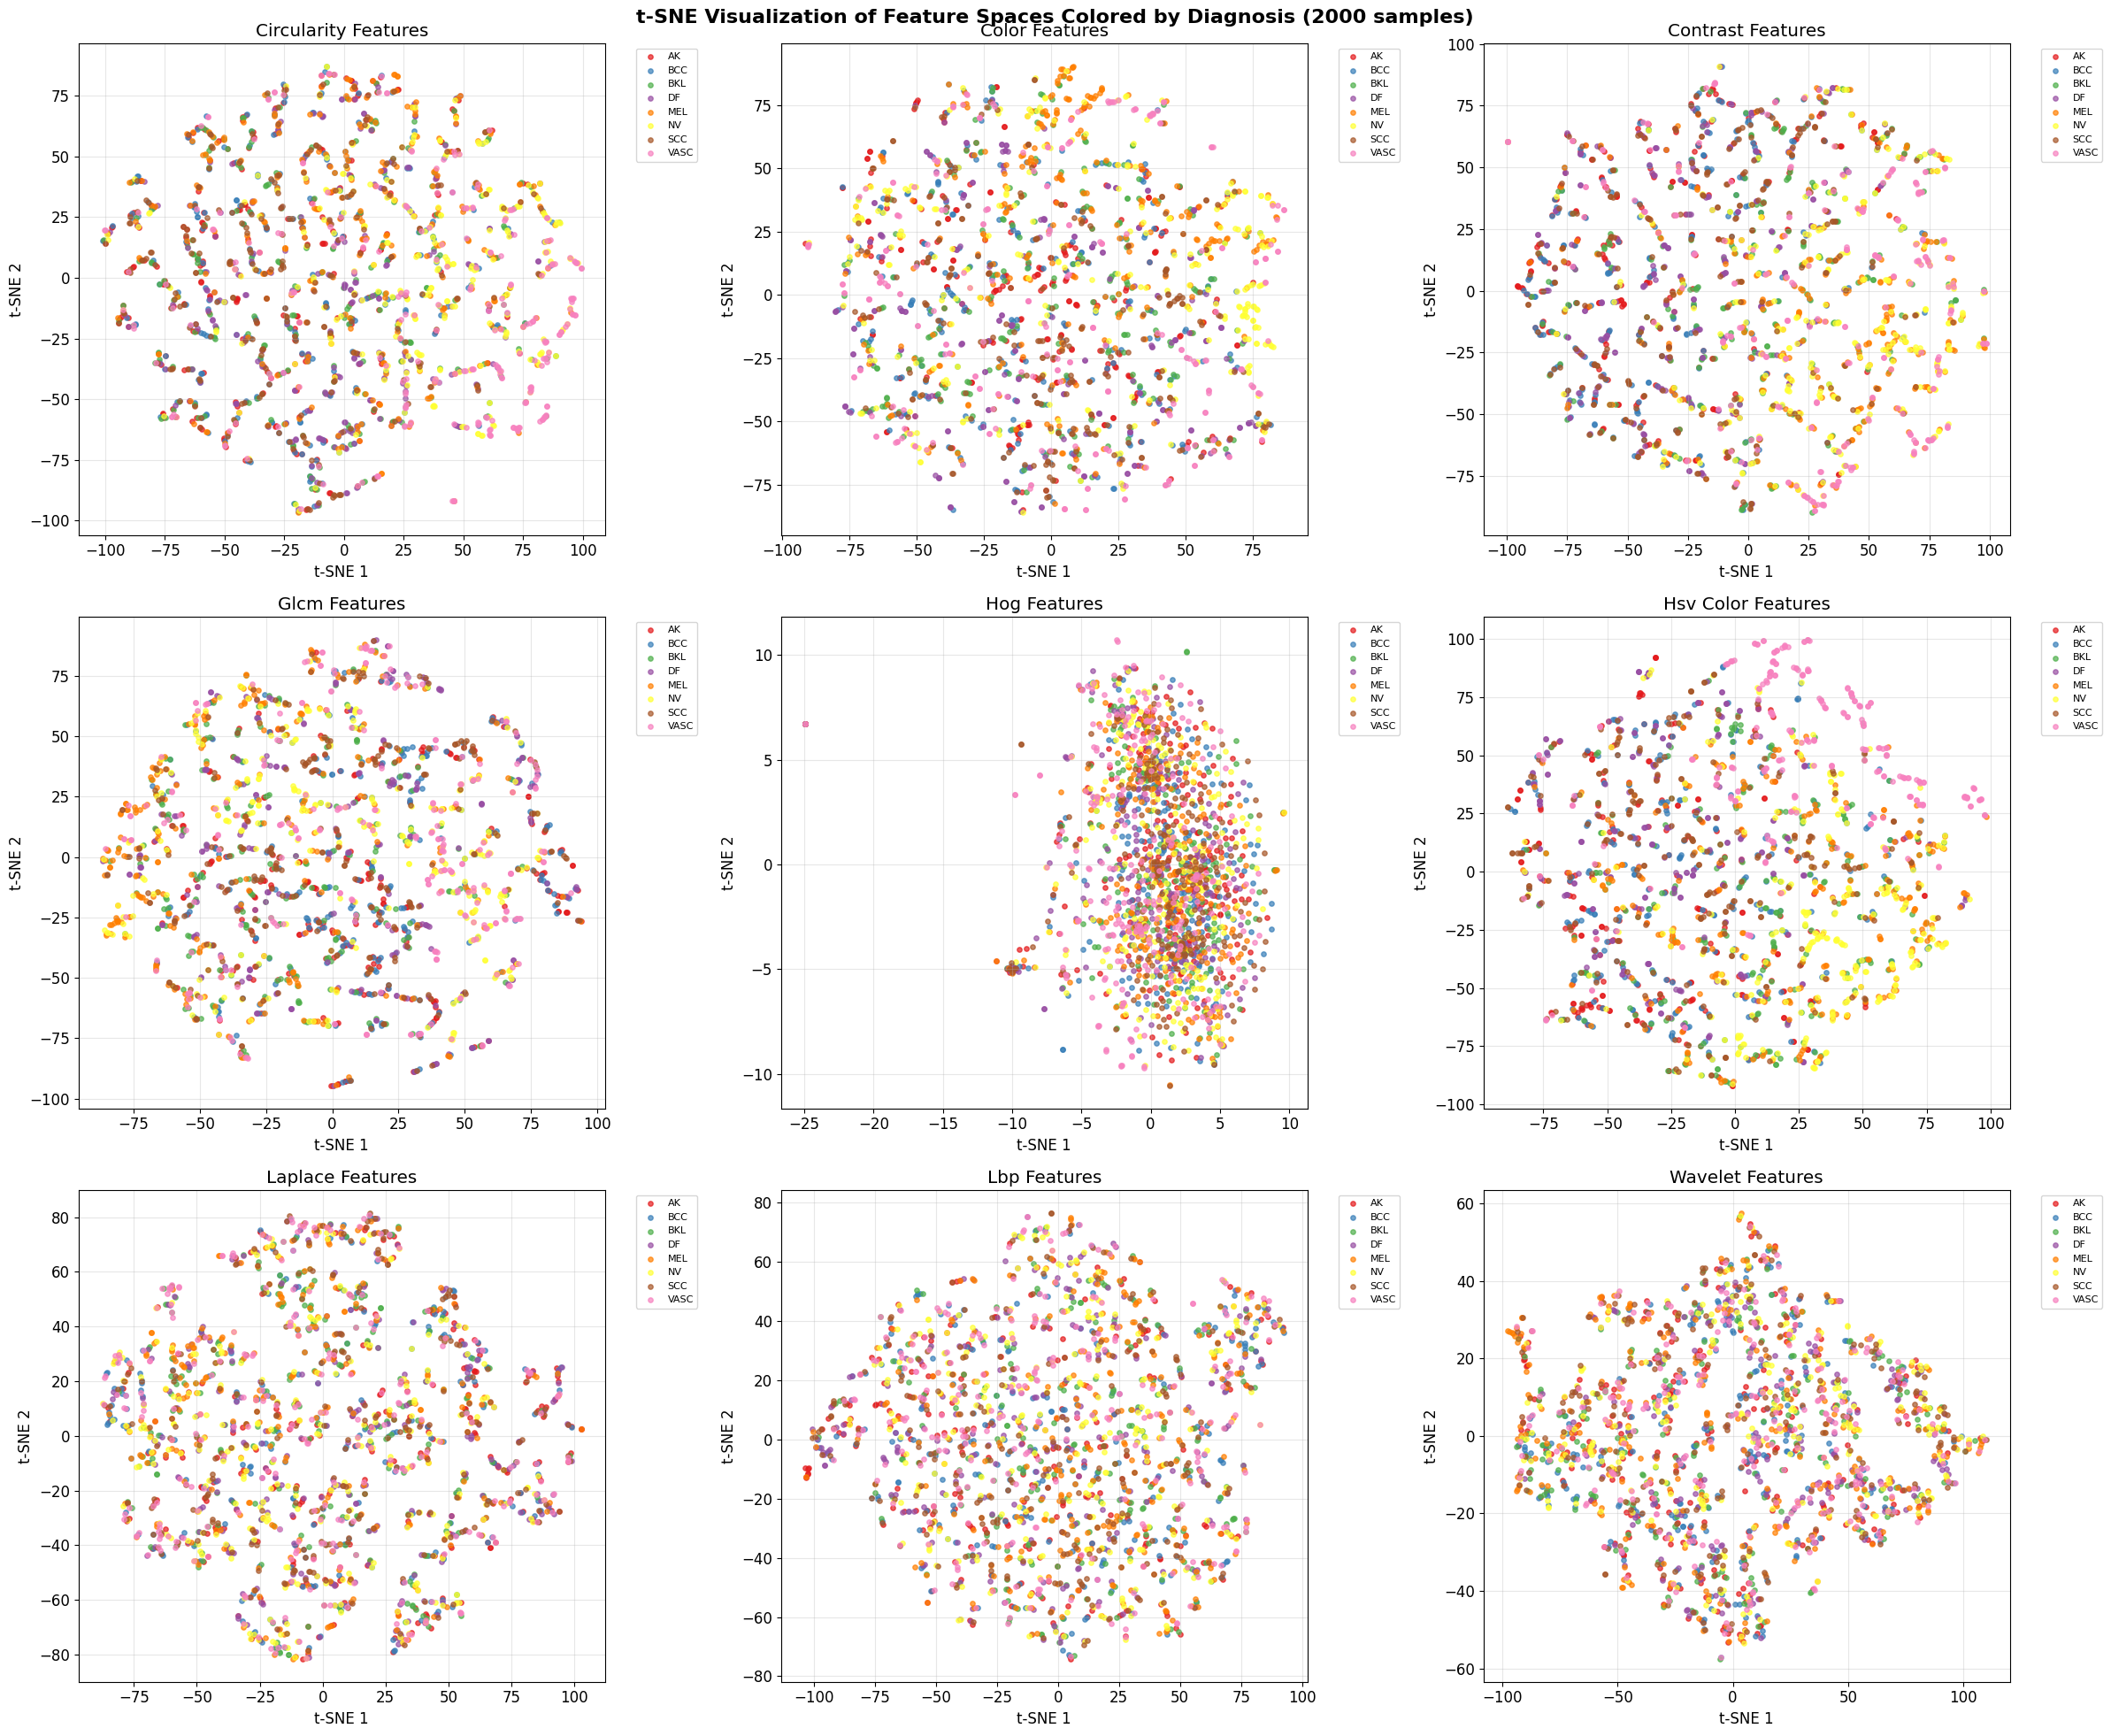


CLASS SEPARABILITY ANALYSIS
Legend:
  AK: Actinic Keratosis
  BCC: Basal Cell Carcinoma
  BKL: Benign Keratosis
  DF: Dermatofibroma
  MEL: Melanoma
  NV: Nevus (Mole)
  SCC: Squamous Cell Carcinoma
  VASC: Vascular Lesion

t-SNE Analysis Complete!
The t-SNE plots show how each feature type organizes the data by diagnosis:
- Well-separated clusters by color indicate good discriminative features
- Mixed colors suggest the feature doesn't separate classes well
- Look for patterns where malignant (MEL, BCC, SCC) vs benign classes cluster separately


In [8]:
# t-SNE visualization with class labels as colors
print("=== t-SNE VISUALIZATION OF FEATURE SPACES WITH CLASS LABELS ===")
print("Comparing how different feature types cluster and separate samples by diagnosis")

# Select a subset of features for comparison (reduce computational cost)
n_samples = 2000  # Use subset for faster t-SNE
np.random.seed(42)  # Set seed for reproducibility
sample_indices = np.random.choice(8000, n_samples, replace=False)

features_subset = {}
for name, data in features_data.items():
    if name == 'efficientnet_features':  # Skip EfficientNet due to size
        continue
    features_subset[name] = data[sample_indices]

# Get corresponding labels for the subset
labels_subset = labels[sample_indices]

# Create color mapping for labels
unique_labels = sorted(metadata_df['label'].unique())
label_colors = plt.cm.Set1(np.arange(len(unique_labels)))
label_color_map = {label: label_colors[i] for i, label in enumerate(unique_labels)}

# Map labels to colors for the subset
subset_colors = [label_color_map[label] for label in labels_subset]

fig, axes = plt.subplots(3, 3, figsize=(24, 20))
fig.suptitle('t-SNE Visualization of Feature Spaces Colored by Diagnosis (2000 samples)', fontsize=16, fontweight='bold')

feature_names = list(features_subset.keys())

for idx, (name, data) in enumerate(features_subset.items()):
    if idx >= 9:  # Limit to 9 subplots
        break
        
    row, col = idx // 3, idx % 3
    
    print(f"\nProcessing {name}...")
    
    # Reduce dimensionality first if needed (for computational efficiency)
    # if data.shape[1] > 50:
    #     # Use PCA to reduce to 50 dimensions first
    #     pca_temp = PCA(n_components=50)
    #     data_reduced = pca_temp.fit_transform(StandardScaler().fit_transform(data))
    #     print(f"  Reduced from {data.shape[1]} to 50 dimensions via PCA")
    # else:
    data_reduced = StandardScaler().fit_transform(data)
        # print(f"  Using original {data.shape[1]} dimensions")
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=5, max_iter=1000)
    tsne_data = tsne.fit_transform(data_reduced)
    
    # Create scatter plot with class labels as colors
    for i, label in enumerate(unique_labels):
        mask = labels_subset == label
        if np.any(mask):
            axes[row, col].scatter(tsne_data[mask, 0], tsne_data[mask, 1], 
                                 c=[label_colors[i]], label=label, alpha=0.7, s=15)
    
    axes[row, col].set_title(f'{name.replace("_", " ").title()}')
    axes[row, col].set_xlabel('t-SNE 1')
    axes[row, col].set_ylabel('t-SNE 2')
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

# Create a summary of class separability for each feature type
print(f"\n" + "="*80)
print("CLASS SEPARABILITY ANALYSIS")
print("="*80)
print("Legend:")
for i, label in enumerate(unique_labels):
    full_names = {
        'AK': 'Actinic Keratosis',
        'BCC': 'Basal Cell Carcinoma', 
        'BKL': 'Benign Keratosis',
        'DF': 'Dermatofibroma',
        'MEL': 'Melanoma',
        'NV': 'Nevus (Mole)',
        'SCC': 'Squamous Cell Carcinoma',
        'VASC': 'Vascular Lesion'
    }
    print(f"  {label}: {full_names.get(label, label)}")

print("\nt-SNE Analysis Complete!")
print("The t-SNE plots show how each feature type organizes the data by diagnosis:")
print("- Well-separated clusters by color indicate good discriminative features")
print("- Mixed colors suggest the feature doesn't separate classes well")
print("- Look for patterns where malignant (MEL, BCC, SCC) vs benign classes cluster separately")